In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import optimizers, layers, models

**Data Exploration and Preprocessing**

In [2]:
ds_path = 'data/mtsamples.csv'
dataset = pd.read_csv(ds_path)
dataset.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [3]:
def check_class_distribution(df, target_col):
    # Check the class distribution
    print("===== Class Distribution =====")
    print(df[target_col].value_counts())
    
    # Visualize the imbalance
    sns.countplot(x=target_col, data=df)
    plt.title('Class Distribution')
    plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB
None
===== Null Summary =====
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64
Dropping rows with missing values...
===== Duplicate Summary =====
Count: 0
===== Class Distribution =====
medical_specialty
Surgery                          1021
Orthopedic                        303
Cardiovascular / Pulmonary        280
Radiology                   

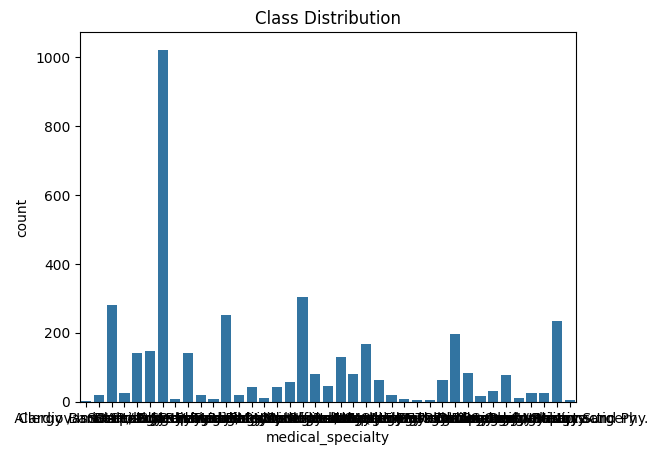

In [4]:
def preprocess_data(df):
    # Handling Missing Values
    null_summary = df.isnull().sum()
    print(f"===== Null Summary =====\n{null_summary}")
    if null_summary.any():
        print("Dropping rows with missing values...")
        df = df.dropna()

    # Checking for Duplicate Values
    duplicate_count = df.duplicated().sum()
    print(f"===== Duplicate Summary =====\nCount: {duplicate_count}")
    if duplicate_count > 0:
        print("Dropping duplicate rows...")
        df = df.drop_duplicates()

    check_class_distribution(df, 'medical_specialty')
    return df

print(dataset.info())
dataset = preprocess_data(dataset)

In [5]:
MAX_SEQ_LEN = 200
EMBEDDING_DIM = 32
BATCH_SIZE = 32
DS_SPLIT = 0.15
MIN_SPECIALITY_THRESHOLD = 100

In [6]:
sub_ds = dataset[['medical_specialty', 'transcription',]]
speciality_count = sub_ds.medical_specialty.value_counts()

filtered_ds = sub_ds[sub_ds.medical_specialty.isin(speciality_count[speciality_count >= MIN_SPECIALITY_THRESHOLD].index)]
filtered_ds.medical_specialty.value_counts()

medical_specialty
Surgery                          1021
Orthopedic                        303
Cardiovascular / Pulmonary        280
Radiology                         251
Consult - History and Phy.        234
Gastroenterology                  195
Neurology                         168
General Medicine                  146
SOAP / Chart / Progress Notes     142
Urology                           140
Obstetrics / Gynecology           130
Name: count, dtype: int64

In [7]:
train_df, test_df = train_test_split(filtered_ds, test_size=DS_SPLIT, random_state=42)
print(f"Train set size: {len(train_df)}, Test set size: {len(test_df)}")

Train set size: 2558, Test set size: 452


In [8]:
# Label encoding
le = LabelEncoder()
le.fit(train_df.medical_specialty)
train_y = le.transform(train_df.medical_specialty)
test_y = le.transform(test_df.medical_specialty)
num_classes = len(le.classes_)
print(f"Classes: {le.classes_}")

Classes: [' Cardiovascular / Pulmonary' ' Consult - History and Phy.'
 ' Gastroenterology' ' General Medicine' ' Neurology'
 ' Obstetrics / Gynecology' ' Orthopedic' ' Radiology'
 ' SOAP / Chart / Progress Notes' ' Surgery' ' Urology']


In [9]:
# Character-level vectorization
raw_train_text = tf.data.Dataset.from_tensor_slices(train_df.transcription.values)

vectorizer = tf.keras.layers.TextVectorization(
    standardize=None,
    split="character",
    max_tokens=None,
    output_mode="int",
    output_sequence_length=MAX_SEQ_LEN
)

vectorizer.adapt(raw_train_text)
vocab_size = vectorizer.vocabulary_size()

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(texts, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(texts))
    ds = ds.map(
        lambda txt, lbl: (vectorizer(txt), lbl),
        num_parallel_calls=AUTOTUNE
    )
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_dataset(train_df.transcription.values, train_y, shuffle=True)
test_ds = make_dataset(test_df.transcription.values, test_y)

**Build RNN model**

In [11]:
def build_rnn_model(rnn_layer, opt, lr=0.001, em_dim=EMBEDDING_DIM):
    model = models.Sequential([
        layers.Input(shape=(MAX_SEQ_LEN,)),
        layers.Embedding(input_dim=vocab_size, output_dim=em_dim, mask_zero=True),
        rnn_layer,
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=opt(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

def train_and_eval(model, epochs=20, callable=[early_stopping]):
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=epochs,
        callbacks=callable
    )

    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")
    return history

In [13]:
bilstm_layer = layers.Bidirectional(layers.LSTM(32))
lstm_model = build_rnn_model(bilstm_layer, optimizers.Adam)
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 32)        │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,587 (80.42 KB)

 Trainable params: 20,587 (80.42 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
lstm_history = train_and_eval(lstm_model, epochs=40)

Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step - accuracy: 0.3128 - loss: 2.2169 - val_accuracy: 0.3872 - val_loss: 1.8380
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.4115 - loss: 1.8498 - val_accuracy: 0.4204 - val_loss: 1.7856
Epoch 3/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.4416 - loss: 1.7538 - val_accuracy: 0.4270 - val_loss: 1.7430
Epoch 4/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.4368 - loss: 1.7311 - val_accuracy: 0.4248 - val_loss: 1.7276
Epoch 5/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.4429 - loss: 1.6774 - val_accuracy: 0.4314 - val_loss: 1.7135
Epoch 6/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.4634 - loss: 1.6443 - val_accuracy: 0.4381 - val_loss: 1.6946
Epoch 7/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.4696 - loss: 1.6157 - val_accuracy: 0.4425 - val_loss: 1.7066
Epoch 8/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.4487 - loss: 1.6522 - val_accuracy: 0

In [ ]:
# def plot_history(history, target_metric):
#     title = target_metric[0].upper() + target_metric[1:]
#     plt.figure(figsize=(10, 6))
#     plt.plot(history.history[target_metric], label=f'Train {title}')
#     plt.plot(history.history[f'val_{target_metric}'], label=f'Test {title}')
#     plt.xlabel('Epochs')
#     plt.ylabel(title)
#     plt.title(f'{title} Trajectory')
#     plt.legend()
#     plt.show()

In [16]:
# print("LSTM Accuracy and Loss Trajectory")
# plot_history(lstm_history, 'accuracy')
# plot_history(lstm_history, 'loss')  

In [17]:
# def classify(model, text, verbose=False):
#     seq = vectorizer(tf.constant([text]))
#     probs = model.predict(seq)[0]
#     lang_id = tf.argmax(probs).numpy()
#     prediction = le.inverse_transform([lang_id])[0]
#     if verbose:
#         print(f"Input Text: {text}")
#         print(f"Prediction: {prediction}")
#     return prediction

# sample_text_1 = ""
# classify(lstm_model, sample_text_1, verbose=True)